# Rossmann销售预测项目 -- 数据集概览

## 数据集初步探索

对数据形成初步印象，查看一些典型特征和标签之间的联系。

In [152]:
import pandas as pd
import os
train = pd.read_csv('data/train.csv')
store = pd.read_csv('data/store.csv')

C:\Users\siyuan\miniconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
# set(train.SchoolHoliday.values)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [163]:
store.head()
# set(store.PromoInterval)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


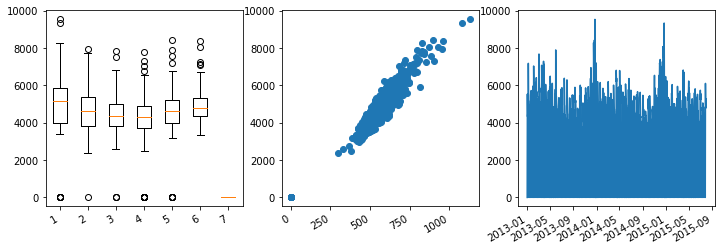

In [18]:
# 分别绘制星期号、客流量和日期与销售额的相关性

import matplotlib.pyplot as plt
from datetime import datetime

store_1 = train[train.Store==1]
cus = store_1.Customers
sales = store_1.Sales
dow = store_1.DayOfWeek
dow_sales = [store_1[store_1.DayOfWeek==i].Sales.values for i in [1,2,3,4,5,6,7]]
dates = [datetime.strptime(d, '%Y-%m-%d').date() for d in store_1.Date.values]

init_explore_fig = plt.figure(figsize=(12,4))

ief_1 = init_explore_fig.add_subplot(131)
ief_1.boxplot(dow_sales)

ief_2 = init_explore_fig.add_subplot(132)
ief_2.scatter(cus,sales)

ief_3 = init_explore_fig.add_subplot(133)
ief_3.plot(dates,sales)
plt.gcf().autofmt_xdate()

plt.show()

## 特征编码处理

数据包含以下特征.根据取值范围，暂定以下编码方案。

- Id - 样本号，无参考作用。
- Store - 门店号，1~1115，不编码。
- Sales - 销售额（本项目的预测内容）。
- Customers - 日客流量。预测集不提供，考虑将该特征整合入店铺特征中
- Open - 用来表征商店开张或闭店的数据，0表示闭店，1表示开张。
- StateHoliday - 法定假期，a表示公共假期，b表示复活节，c表示圣诞节，0则意味着不是假期。考虑进行独热编码。
- SchoolHoliday - 0,1数值，不需要处理
- StoreType - 使用a,b,c,d四个值来表征四种不同类型的商店，应当独立热码
- Assortment - 表征所售商品品类的等级，a为基础型，b为大型，c为特大型。应当独立热码
- CompetitionDistance - 距离最近竞争商家的距离（m）。连续数值量，考虑放缩
- CompetitionOpenSince[Month/Year] - 距离最近竞争商家的开业时间。日期量，以分割为年和月
- Promo - 表征某天是否有促销活动。
- Promo2 - 表征门店是否在持续推出促销活动
- Promo2Since[Year/Week] - 以年和年中周数表征该门店参与持续促销的时间。日期量，以分割为年和月
- PromoInterval - 'Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', nan,四种取值，考虑独立热码为 is_interval,is_fman,is_jajo,is_mjsd

In [40]:
# set(store.PromoInterval.values.tolist())

{'Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', nan}

在执行编码之前，我们先对缺失值进行搜索和填充。

In [157]:
import numpy as np

train_cols = train.columns.values
store_cols = store.columns.values

print(train_cols,store_cols)

for c in train_cols:
    NaN_lenth = len([i for i in train[c] if pd.isnull(i)])
    if NaN_lenth!=0:
        print(c,'miss',NaN_lenth)

for c in store_cols:
    NaN_lenth = len([i for i in store[c] if pd.isnull(i)])
    if NaN_lenth!=0:
        print(c,'miss',NaN_lenth)

['Store' 'DayOfWeek' 'Date' 'Sales' 'Customers' 'Open' 'Promo'
 'StateHoliday' 'SchoolHoliday'] ['Store' 'StoreType' 'Assortment' 'CompetitionDistance'
 'CompetitionOpenSinceMonth' 'CompetitionOpenSinceYear' 'Promo2'
 'Promo2SinceWeek' 'Promo2SinceYear' 'PromoInterval']
CompetitionDistance miss 3
CompetitionOpenSinceMonth miss 354
CompetitionOpenSinceYear miss 354
Promo2SinceWeek miss 544
Promo2SinceYear miss 544
PromoInterval miss 544


In [164]:
len(store)

1115